## Wczytaj potrzebne biblioteki

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
TRAINTESTRATIO = 0.33

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))

pandas version: 1.0.3
numpy version: 1.18.4
matplotlib version: 3.2.0


## Wczytaj dane

In [2]:
def changeDateToSeconds(df):
    first = df["date"][0]
    df["date"] = df["date"].apply(lambda timestamp: (timestamp-first).seconds)
    return df

def readDataFromExcel(path, sheet):
    df = pd.read_excel(path, sheet_name=sheet, na_values=[" Bad Data","Bad Data"])
    df["date"] = pd.to_datetime(df["date"])
    df = changeDateToSeconds(df)
    return df

df2 = readDataFromExcel("./data/K-1_MI.xlsx", "d2")
df3 = readDataFromExcel("./data/K-1_MI.xlsx", "d3")
df5 = readDataFromExcel("./data/K-1_MI.xlsx", "d5")
df6 = readDataFromExcel("./data/K-1_MI.xlsx", "d6")

df6 = df6.iloc[::5, :] # dopasuj okresy próbkowania

dataFrames = [df2, df3, df5, df6]

## Skalowanie i oczyszczanie danych

In [3]:
scaledDf = df2.append(df3).append(df5).append(df6)
scaler = preprocessing.StandardScaler()
scaledDf = scaledDf.drop(["date"], axis=1)
columns = scaledDf.columns

scaler.fit(scaledDf)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [4]:
scaledDataFrames = list()
for df in dataFrames:
    df = scaler.transform(df.drop(["date"], axis=1))
    scaledDataFrames.append(pd.DataFrame(df, columns=columns))

### Tworzenie macierzy regresji

In [5]:
def prepareSignals(df, inputs, output, medfilt=False, kernelSize=11):
    inputSignals = df[inputs]
    outputSignal = df[output]
    inputFrame = pd.concat([inputSignals, outputSignal.shift(1)], axis=1).iloc[1:]

    if(medfilt == True):
        u_signals = applyMedianFilter(inputFrame.to_numpy(), kernelSize)
        y_signal = applyMedianFilter(df[output].iloc[1:].to_numpy(), kernelSize)

    else:
        u_signals = inputFrame.to_numpy()
        y_signal =  df[output].iloc[1:].to_numpy()
        
    return (u_signals, y_signal)

In [6]:
def createModelMatrixForSingleInput(data, order, delay, exponent):
    if(order < 0 or delay < 0 or exponent <= 0):
        raise AssertionError("Invalid structure parameter")
        
    samples = data.shape[0]
    widthCoefficient = (order + 1)*exponent
    heightAbsoluteTerm = order + delay
    
    A = np.zeros([samples - heightAbsoluteTerm, widthCoefficient])
    
    for j in range(order+1):
        for k in range(exponent):
            colIndex = (order-j)*exponent + k
            A[:, colIndex] = np.power(data[j : samples-heightAbsoluteTerm+j], k+1)
    
    return A

In [7]:
def findMaxDelayAndOrder(M):
    maxDelay = 0; maxOrder = 0
    for index, parameters in enumerate(M.T):
        order, delay, exponent = parameters
        if(order > maxOrder):
            maxOrder = order
        if(delay > maxDelay):
            maxDelay = delay
    
    return maxDelay, maxOrder

In [8]:
def createModelMatrix(data, M):
    if(M.shape[0] != 3):
        raise AssertionError("Invalid parameter vector size")

    if(M.shape[1] != data.shape[1]):
        raise AssertionError("Mismatched size of data: {} and M: {} vector".format(data.shape, M.shape))
        
    inputs = M.shape[1]
    height = data.shape[0]
    
    maxDelay, maxOrder = findMaxDelayAndOrder(M)
    A = np.empty(shape=(height-maxOrder-maxDelay, 0)) 
    for index, parameters in enumerate(M.T):
        # stworz macierz dla danego wejscia
        inputData = data[:, index]
        order, delay, exponent = parameters
        Ap = createModelMatrixForSingleInput(data[:, index], order, delay, exponent)
        
        # obetnij macierz - delay od góry, a order od dołu macierzy
        delayMaxDiff = np.abs(maxDelay-delay)
        orderMaxDiff = np.abs(maxOrder-order)
        baseHeight = Ap.shape[0]
        validA = Ap[orderMaxDiff+delayMaxDiff:]
        validA = validA[:A.shape[0]]
        
        # dodaj do akumulatora
        A = np.concatenate((A, validA), axis=1)
        
    return A

In [9]:
def evalModelScore(model, M, u_verif, y_verif):
    maxDelay, maxOrder = findMaxDelayAndOrder(M)   
    numberOfSamples = y_verif.shape[0]
    output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]
    
    data_idx = maxOrder+maxDelay+1
    u_verif_wip = np.array(u_verif[0:data_idx],copy=True)
    A_verif = createModelMatrix(u_verif_wip, M)
    
    model_outputs = np.array([])
    for i in range(data_idx, data_idx+len(output_verif_cut)):
        output_model_verif = model.predict(A_verif)
        model_outputs = np.append(model_outputs, output_model_verif)
        u_verif_wip = np.vstack((u_verif_wip, u_verif[data_idx:data_idx+1]))[1:]
        data_idx += 1
        u_verif_wip[-1][-1] = output_model_verif[-1]
        A_verif = createModelMatrix(u_verif_wip, M) 
        
    verif_score = r2_score(output_verif_cut, model_outputs)
    return verif_score

## Oblicz wynik modelu

In [10]:
def crossValidate(M, dataFrames, inputs, outputs):
    maxDelay, maxOrder = findMaxDelayAndOrder(M)
    regressors = inputs + outputs
    scores = list()
    for df_verif in dataFrames:
        u_verif, y_verif = prepareSignals(df_verif, inputs, outputs)
        A_learn = None
        y_learn = None
        for df_learn in dataFrames:
            if df_verif.equals(df_learn):
                continue
            
            u, y = prepareSignals(df_learn, inputs, outputs)
            A = createModelMatrix(u, M)
            
            if A_learn is None:
                A_learn = np.empty((0, A.shape[1]))
            if y_learn is None:
                y_learn = np.empty((0, y.shape[1]))
            
            numberOfSamples = y.shape[0]
            y_cut = y[maxDelay : numberOfSamples - maxOrder]
            A_learn = np.vstack((A_learn, A))
            y_learn = np.vstack((y_learn, y_cut))
        
        
        model = linear_model.LinearRegression().fit(A_learn, y_learn)
        score = evalModelScore(model, M, u_verif, y_verif)
        scores.append(score)
    
    return sum(scores)/len(scores)

## Uruchom algorytm genetyczny do znalezienia struktury modelu

In [11]:
inputs = ['FP05', 'LT1', 'TMB', 'TMC', 'TMD', 'TME', 'TMF', 'PWB', 'PWC', 'PWD',
       'PWE', 'PP', 'PW1', 'PW2', 'O2A', 'O2B', 'WP1', 'WDP', 'TP1', 'TP2',
       'DP', 'TS1', 'TS2', 'FWF', 'ZS1', 'ZS2', 'PT05', 'PT01', 'TS01',
       'TS03', 'TS02', 'FW01', 'TS05', 'TS04', 'FW02', 'TTWS', 'PTWS', 'TW02',
       'TW01', 'FW03', 'TW04', 'TW03', 'FW04', 'PTWT', 'PPW']
output = ["LT01"]

cache = {}

def goalFunction(x):
    # zbuduj macierz M na podstawie wektora x
    M = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
    for index, value in enumerate(x):
        row = index % 3; col = index // 3
        M[row, col] = int(value)
        
    M_hash = hash(str(M))
    if M_hash in cache:
        score = cache[M_hash]
    else:
        score = crossValidate(M, scaledDataFrames, inputs, output)
        cache[M_hash] = score
        
    return (-1)*score

In [12]:
# bounds = [(0, 5), (0,30), (1, 2)]*(len(inputs) + 1)
# bounds[-2] = (0,0)
# result = differential_evolution(goalFunction, bounds, disp=True, polish=False, tol=10.0, updating="deferred", workers=4)
# result

### Dla znalezionej struktury określ model

[[ 1 20  1]
 [ 4  4  1]
 [ 2 16  1]
 [ 3 20  1]
 [ 0 24  1]
 [ 1  6  1]
 [ 2 16  1]
 [ 1  4  1]
 [ 4  2  1]
 [ 4 27  1]
 [ 0  1  1]
 [ 4  2  1]
 [ 0 20  1]
 [ 4  8  1]
 [ 1  7  1]
 [ 1  7  1]
 [ 2  9  1]
 [ 4  3  1]
 [ 3  2  1]
 [ 4  7  1]
 [ 1 20  1]
 [ 0 26  1]
 [ 1  1  1]
 [ 4  4  1]
 [ 0 10  1]
 [ 2 23  1]
 [ 0 12  1]
 [ 4 17  1]
 [ 2 20  1]
 [ 4  8  1]
 [ 4  8  1]
 [ 1 28  1]
 [ 4 13  1]
 [ 2  5  1]
 [ 4  2  1]
 [ 0 16  1]
 [ 0 20  1]
 [ 4  1  1]
 [ 1 25  1]
 [ 0 22  1]
 [ 3 10  1]
 [ 1 17  1]
 [ 3 15  1]
 [ 1 28  1]
 [ 3  4  1]
 [ 1  0  1]]
(966, 141)
(966, 1)
(318,)
(318,)
(318,)
(55,)
0.5782032052720707


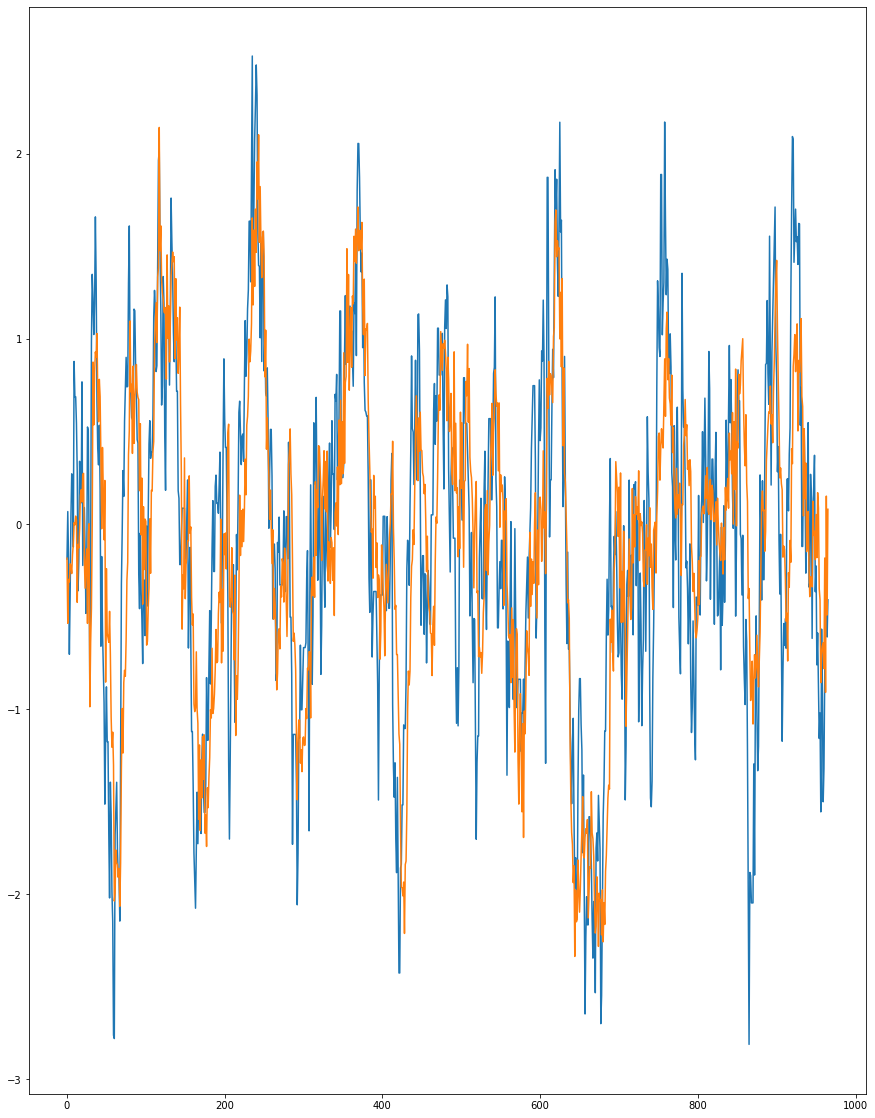

In [15]:
optimM = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
x_lt = [ 1.7701155 , 20.42044817,  1.0696059 ,  4.24664564,  4.92101608,
        1.97355617,  2.86239253, 16.1645101 ,  1.66333762,  3.42945442,
       20.67018491,  1.95952461,  0.49735925, 24.66395883,  1.09881886,
        1.87718693,  6.8901269 ,  1.74799679,  2.35497816, 16.70582063,
        1.14604248,  1.78811223,  4.45881446,  1.09081917,  4.80668833,
        2.96673985,  1.68287176,  4.18526576, 27.14567904,  1.13750605,
        0.50108797,  1.28975182,  1.48211115,  4.76563616,  2.93546243,
        1.5680497 ,  0.9815658 , 20.50288737,  1.16098592,  4.84797307,
        8.07287821,  1.22344099,  1.70040561,  7.06472365,  1.55614365,
        1.91892749,  7.53175512,  1.87336521,  2.19237624,  9.22362428,
        1.43968363,  4.61703101,  3.00241619,  1.02480086,  3.84844481,
        2.98543174,  1.98854448,  4.15810407,  7.49942245,  1.16316851,
        1.68351327, 20.88848305,  1.26539871,  0.23534996, 26.93541524,
        1.13202141,  1.00011842,  1.2314162 ,  1.36340971,  4.17133404,
        4.0709321 ,  1.77680246,  0.9618587 , 10.51148858,  1.67961177,
        2.09718865, 23.35524675,  1.23857035,  0.40617127, 12.1235022 ,
        1.29249533,  4.04405794, 17.15620693,  1.5403893 ,  2.22480785,
       20.30902946,  1.39496053,  4.81993547,  8.77014467,  1.38414011,
        4.0929948 ,  8.06932404,  1.97682956,  1.81088413, 28.27235565,
        1.11049796,  4.41889317, 13.41025221,  1.26914058,  2.07457723,
        5.52968537,  1.68589608,  4.01931304,  2.75461603,  1.13705236,
        0.19423334, 16.49841614,  1.61762591,  0.15478458, 20.33589279,
        1.34828656,  4.21659779,  1.76564941,  1.09894828,  1.47864526,
       25.42152635,  1.72956755,  0.86075329, 22.00225385,  1.20055797,
        3.3444737 , 10.29158345,  1.82314923,  1.86601314, 17.6276732 ,
        1.91012264,  3.49438076, 15.32824042,  1.62821668,  1.92923466,
       28.70373631,  1.36087409,  3.9924326 ,  4.49536757,  1.81439466,
        1.40748834,  0.        ,  1.24886907]

for index, value in enumerate(x_lt):
    row = index % 3; col = index // 3
    optimM[row, col] = int(value)
print(optimM.transpose())

u_learn, y_learn = prepareSignals(scaledDataFrames[0], inputs, output)
u_verif, y_verif = prepareSignals(scaledDataFrames[0], inputs, output)

maxDelay, maxOrder = findMaxDelayAndOrder(optimM)   
numberOfSamples = y_learn.shape[0]
output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]
A_learn = createModelMatrix(u_learn, optimM)
                            
df0l = pd.DataFrame(A_learn)
print(df0l.shape)
print(output_learn_cut.shape)
df0l.insert(df0l.shape[1]-1, "y_learn", output_learn_cut)
[train0, test0] = train_test_split(df0l, train_size=TRAINTESTRATIO, random_state=0) 

u_learn1, y_learn1 = prepareSignals(scaledDataFrames[1], inputs, output)
u_verif1, y_verif1 = prepareSignals(scaledDataFrames[1], inputs, output)
numberOfSamples = y_learn1.shape[0]
output_learn_cut1 = y_learn1[maxDelay : numberOfSamples - maxOrder]
output_verif_cut1 = y_verif1[maxDelay : numberOfSamples - maxOrder]
A_learn1 = createModelMatrix(u_learn1, optimM)

df1l = pd.DataFrame(A_learn1)
df1l.insert(df1l.shape[1]-1, "y_learn", output_learn_cut1)
[train1, test1] = train_test_split(df1l, train_size=TRAINTESTRATIO, random_state=0) 
                            
u_learn2, y_learn2 = prepareSignals(scaledDataFrames[2], inputs, output)
u_verif2, y_verif2 = prepareSignals(scaledDataFrames[2], inputs, output)
numberOfSamples = y_learn2.shape[0]
output_learn_cut2 = y_learn2[maxDelay : numberOfSamples - maxOrder]
output_verif_cut2 = y_verif2[maxDelay : numberOfSamples - maxOrder]
A_learn2 = createModelMatrix(u_learn2, optimM)
                            
df2l = pd.DataFrame(A_learn2)
df2l.insert(df2l.shape[1]-1, "y_learn", output_learn_cut2)
[train2, test2] = train_test_split(df2l, train_size=TRAINTESTRATIO, random_state=0) 
                            
u_learn3, y_learn3 = prepareSignals(scaledDataFrames[3], inputs, output)
u_verif3, y_verif3 = prepareSignals(scaledDataFrames[3], inputs, output)
numberOfSamples = y_learn3.shape[0]
output_learn_cut3 = y_learn3[maxDelay : numberOfSamples - maxOrder]
output_verif_cut3 = y_verif3[maxDelay : numberOfSamples - maxOrder]
A_learn3 = createModelMatrix(u_learn3, optimM)
                            
df3l = pd.DataFrame(A_learn3)
df3l.insert(df3l.shape[1]-1, "y_learn", output_learn_cut3)   
[train3, test3] = train_test_split(df3l, train_size=TRAINTESTRATIO, random_state=0)                           

print(train0["y_learn"].values.shape)
print(train1["y_learn"].values.shape)
print(train2["y_learn"].values.shape)
print(train3["y_learn"].values.shape)
                            
Al = np.vstack((train0.drop(["y_learn"],axis=1).values, train1.drop(["y_learn"],axis=1).values, train2.drop(["y_learn"],axis=1).values, train3.drop(["y_learn"],axis=1).values))
yl = np.concatenate((train0["y_learn"].values, train1["y_learn"].values, train2["y_learn"].values, train3["y_learn"].values))

model = linear_model.LinearRegression().fit(Al, yl)
score = evalModelScore(model, optimM, u_verif, y_verif)

maxDelay, maxOrder = findMaxDelayAndOrder(optimM)
numberOfSamples = y_learn.shape[0]
output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]

# A_verif = createModelMatrix(u_verif, optimM)
A_learn = createModelMatrix(u_learn, optimM)
y_model_learn = model.predict(Al)
# y_model_verif = model.predict(A_verif)

data_idx = maxOrder+maxDelay+1
u_verif_wip = np.array(u_verif[0:data_idx],copy=True)
A_verif = createModelMatrix(u_verif_wip, optimM)
    
model_outputs = np.array([])
for i in range(data_idx, data_idx+len(output_verif_cut)):
    output_model_verif = model.predict(A_verif)
    model_outputs = np.append(model_outputs, output_model_verif)
    u_verif_wip = np.vstack((u_verif_wip, u_verif[data_idx:data_idx+1]))[1:]
    data_idx += 1
    u_verif_wip[-1][-1] = output_model_verif[-1]
    A_verif = createModelMatrix(u_verif_wip, optimM) 
        
verif_score = r2_score(output_verif_cut, model_outputs)
print(verif_score)

# plot data
plt.rcParams['figure.figsize'] = [15, 20]
plt.plot(output_verif_cut)
plt.plot(model_outputs)
pdres = pd.DataFrame(np.array([output_verif_cut[:,0], model_outputs]).transpose())
pdres.to_csv("./results/genetic/lt01_0.csv", index=False, header=False)

0.37960769564311925


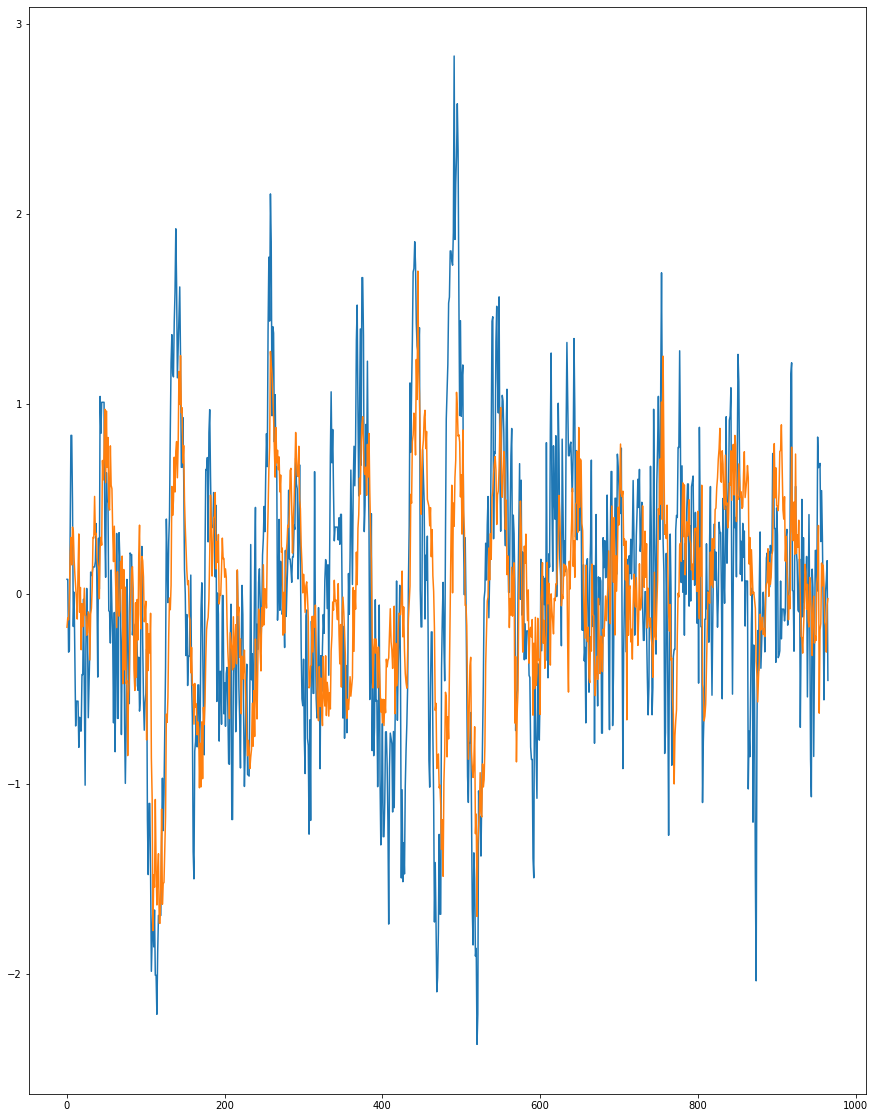

In [16]:
data_idx_1 = maxOrder+maxDelay+1
u_verif_wip_1 = np.array(u_verif1[0:data_idx_1],copy=True)
A_verif_1 = createModelMatrix(u_verif_wip_1, optimM)
    
model_outputs_1 = np.array([])
for i in range(data_idx_1, data_idx_1+len(output_learn_cut1)):
    output_model_verif1 = model.predict(A_verif_1)
    model_outputs_1 = np.append(model_outputs_1, output_model_verif1)
    u_verif_wip_1 = np.vstack((u_verif_wip_1, u_verif1[data_idx_1:data_idx_1+1]))[1:]
    data_idx_1 += 1
    u_verif_wip_1[-1][-1] = output_model_verif1[-1]
    A_verif_1 = createModelMatrix(u_verif_wip_1, optimM) 
        
verif_score1 = r2_score(output_verif_cut1, model_outputs_1)
print(verif_score1)

# plot data
plt.rcParams['figure.figsize'] = [15, 20]
plt.plot(output_verif_cut1)
plt.plot(model_outputs_1)
pdres = pd.DataFrame(np.array([output_verif_cut1[:,0], model_outputs_1]).transpose())
pdres.to_csv("./results/genetic/lt01_1.csv", index=False, header=False)

0.7957536808606751


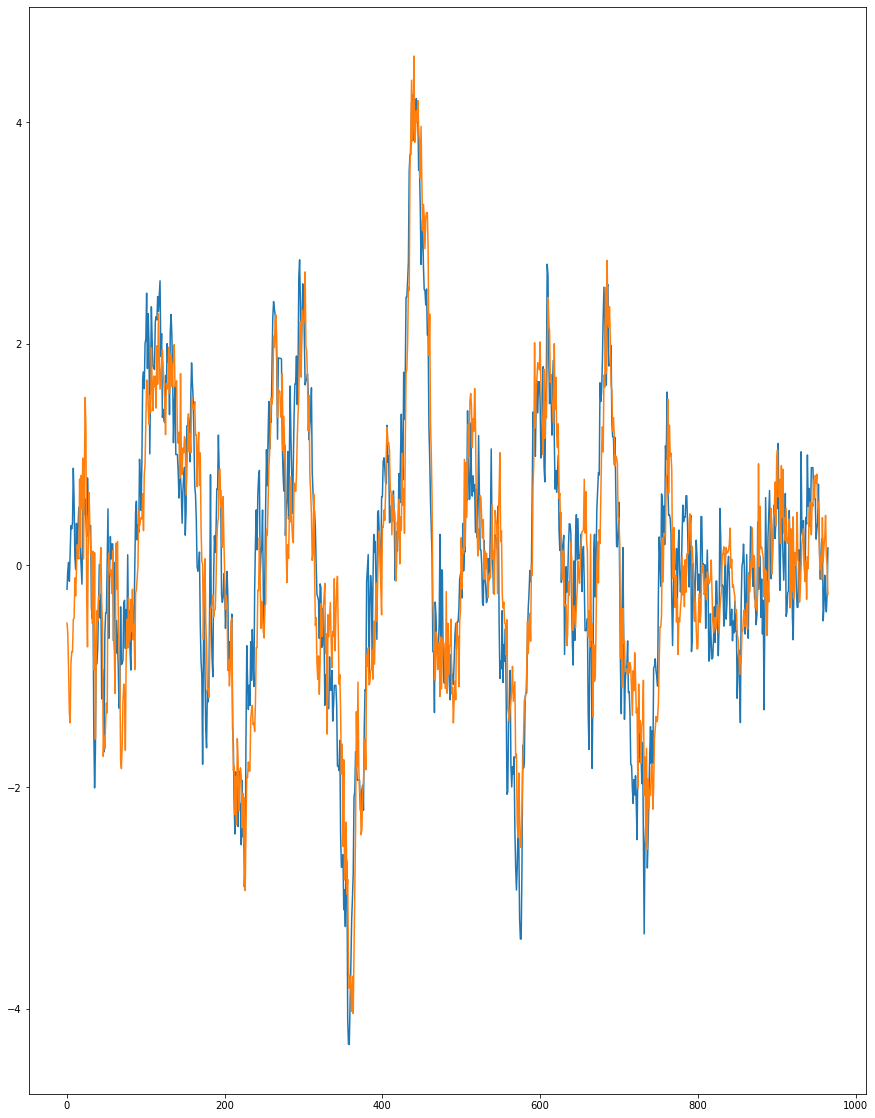

In [17]:
u_learn2, y_learn2 = prepareSignals(scaledDataFrames[2], inputs, output)
u_verif2, y_verif2 = prepareSignals(scaledDataFrames[2], inputs, output)
numberOfSamples = y_learn2.shape[0]
output_learn_cut2 = y_learn2[maxDelay : numberOfSamples - maxOrder]
output_verif_cut2 = y_verif2[maxDelay : numberOfSamples - maxOrder]
A_learn2 = createModelMatrix(u_learn2, optimM)
#

data_idx_2 = maxOrder+maxDelay+1
u_verif_wip_2 = np.array(u_verif2[0:data_idx_2],copy=True)
A_verif_2 = createModelMatrix(u_verif_wip_2, optimM)
    
model_outputs_2 = np.array([])
for i in range(data_idx_2, data_idx_2+len(output_learn_cut2)):
    output_model_verif2 = model.predict(A_verif_2)
    model_outputs_2 = np.append(model_outputs_2, output_model_verif2)
    u_verif_wip_2 = np.vstack((u_verif_wip_2, u_verif2[data_idx_2:data_idx_2+1]))[1:]
    data_idx_2 += 1
    u_verif_wip_2[-1][-1] = output_model_verif2[-1]
    A_verif_2 = createModelMatrix(u_verif_wip_2, optimM) 
        
verif_score2 = r2_score(output_verif_cut2, model_outputs_2)
print(verif_score2)

# plot data
plt.rcParams['figure.figsize'] = [15, 20]
plt.plot(output_verif_cut2)
plt.plot(model_outputs_2)
pdres = pd.DataFrame(np.array([output_verif_cut2[:,0], model_outputs_2]).transpose())
pdres.to_csv("./results/genetic/lt01_2.csv", index=False, header=False)

0.337125971364466


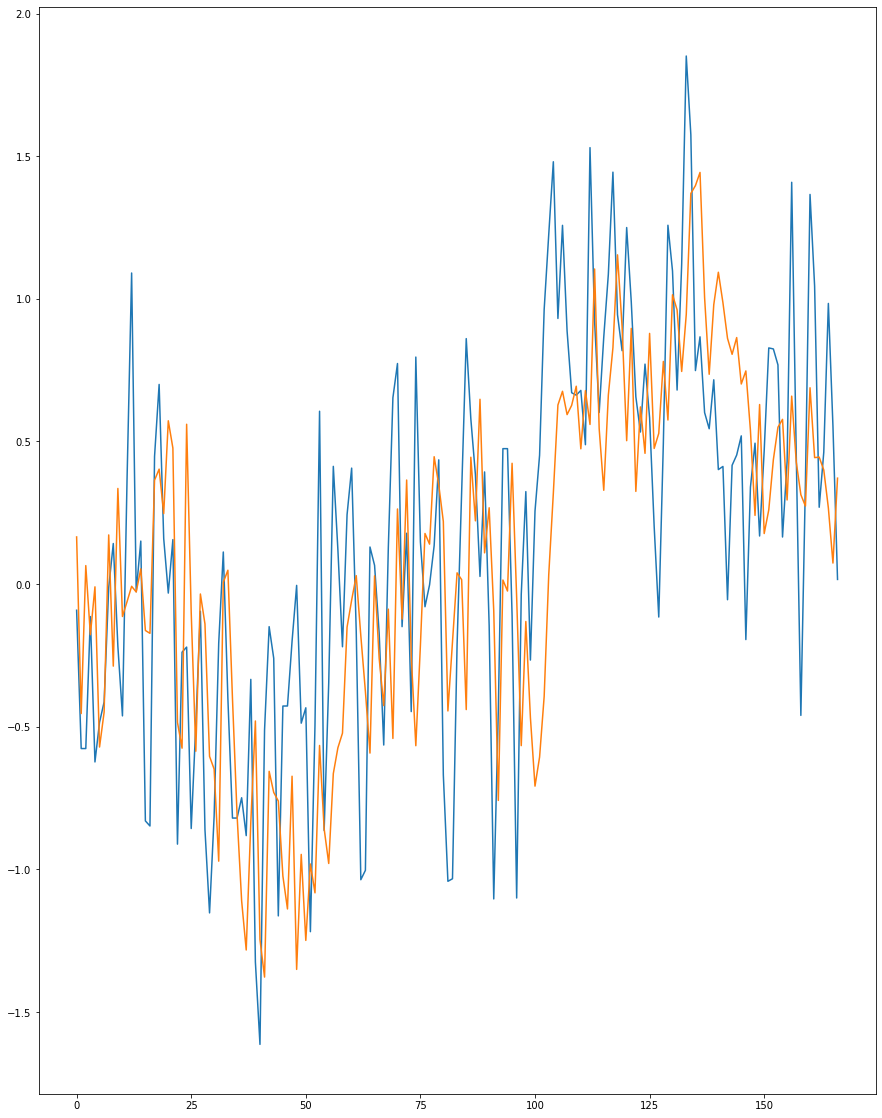

In [18]:
u_learn3, y_learn3 = prepareSignals(scaledDataFrames[3], inputs, output)
u_verif3, y_verif3 = prepareSignals(scaledDataFrames[3], inputs, output)
numberOfSamples = y_learn3.shape[0]

output_learn_cut3 = y_learn3[maxDelay : numberOfSamples - maxOrder]
output_verif_cut3 = y_verif3[maxDelay : numberOfSamples - maxOrder]
A_learn3 = createModelMatrix(u_learn3, optimM)
#

data_idx_3 = maxOrder+maxDelay+1
u_verif_wip_3 = np.array(u_verif3[0:data_idx_3],copy=True)
A_verif_3 = createModelMatrix(u_verif_wip_3, optimM)
    
model_outputs_3 = np.array([])
for i in range(data_idx_3, data_idx_3+len(output_learn_cut3)):
    output_model_verif3 = model.predict(A_verif_3)
    model_outputs_3 = np.append(model_outputs_3, output_model_verif3)
    u_verif_wip_3 = np.vstack((u_verif_wip_3, u_verif3[data_idx_3:data_idx_3+1]))[1:]
    data_idx_3 += 1
    u_verif_wip_3[-1][-1] = output_model_verif3[-1]
    A_verif_3 = createModelMatrix(u_verif_wip_3, optimM) 
        
verif_score3 = r2_score(output_verif_cut3, model_outputs_3)
print(verif_score3)

# plot data
plt.rcParams['figure.figsize'] = [15, 20]
plt.plot(output_verif_cut3)
plt.plot(model_outputs_3)
pdres = pd.DataFrame(np.array([output_verif_cut3[:,0], model_outputs_3]).transpose())
pdres.to_csv("./results/genetic/lt01_3.csv", index=False, header=False)

In [35]:
inputsdp = ['FP05', 'LT1', 'TMB', 'TMC', 'TMD', 'TME', 'TMF', 'PWB', 'PWC', 'PWD',
       'PWE', 'PP', 'PW1', 'PW2', 'O2A', 'O2B', 'WP1', 'WDP', 'TP1', 'TP2',
       'LT01', 'TS1', 'TS2', 'FWF', 'ZS1', 'ZS2', 'PT05', 'PT01', 'TS01',
       'TS03', 'TS02', 'FW01', 'TS05', 'TS04', 'FW02', 'TTWS', 'PTWS', 'TW02',
       'TW01', 'FW03', 'TW04', 'TW03', 'FW04', 'PTWT', 'PPW']
outputdp = ["DP"]
TRAINTESTRATIO = 0.33

cachedp = {}

def goalFunctiondp(x):
    # zbuduj macierz M na podstawie wektora x
    M = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
    for index, value in enumerate(x):
        row = index % 3; col = index // 3
        M[row, col] = int(value)
        
    M_hash = hash(str(M))
    if M_hash in cachedp:
        score = cachedp[M_hash]
    else:
        score = crossValidate(M, scaledDataFrames, inputsdp, outputdp)
        cachedp[M_hash] = score
        
    return (-1)*score

In [ ]:
# boundsdp = [(0, 5), (0,30), (1, 2)]*(len(inputs) + 1)
# boundsdp[-2] = (0,0)
# result = differential_evolution(goalFunctiondp, bounds, disp=True, polish=False, tol=10.0, updating="deferred", workers=4)
# result

[[ 4  4  3  2  0  1  0  3  2  1  0  3  1  1  1  3  4  3  3  0  1  3  1  1
   4  4  0  3  4  2  0  1  4  3  1  4  2  4  4  4  4  2  0  3  4  0]
 [ 2 19 28 27 16  2 16  8 27 27  3 16 11 14 22  9  6 15  9  8 21 15 29 25
  15  4 15 23  9  2 29 25 27  4 14  9 15  4 23 21 21 13  0  1 27  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]]
(1008, 148)
0.6830909400025446


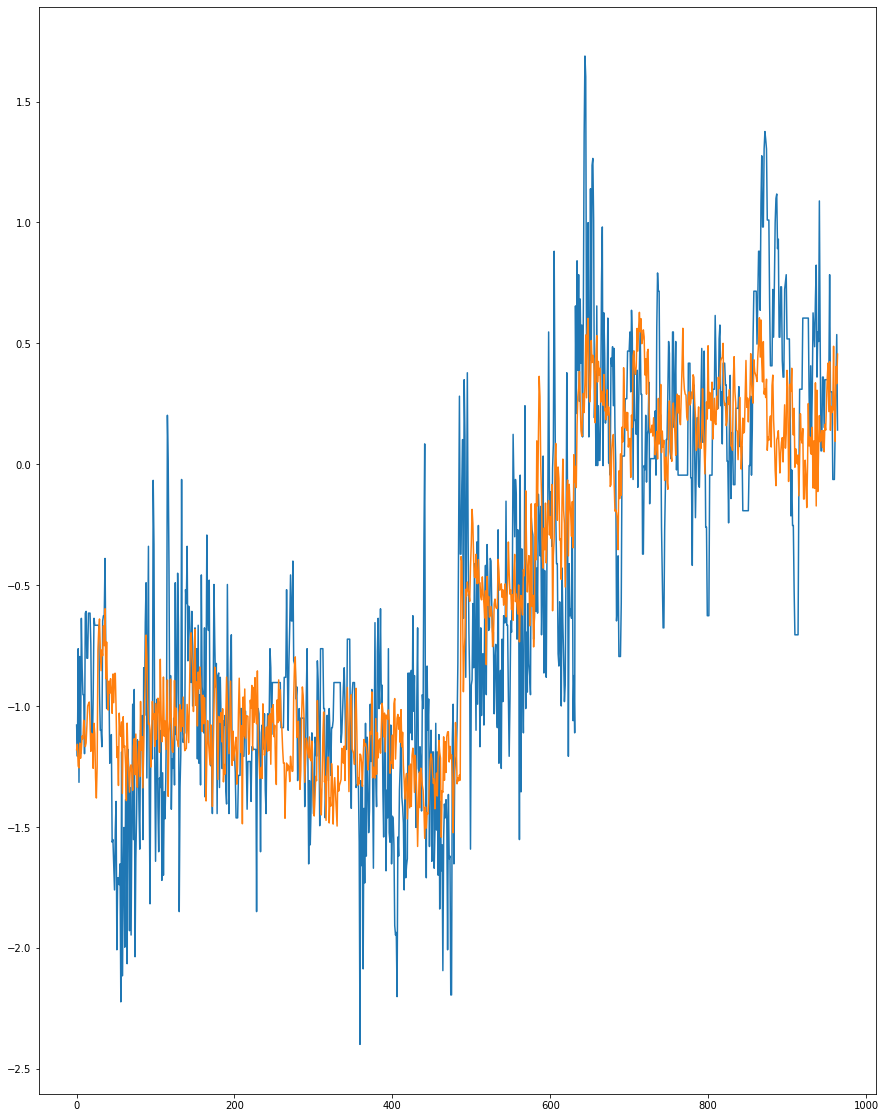

In [52]:
optimM = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
x_dp = [ 4.89078057,  2.47483791,  1.76806009,  4.61717809, 19.32356691,
        1.18911472,  3.98015208, 28.75301027,  1.66776399,  2.13562422,
       27.21910022,  1.80573635,  0.48412577, 16.31968102,  1.27735119,
        1.63509971,  2.28790912,  1.10418449,  0.10421225, 16.67434885,
        1.22078903,  3.91386897,  8.66274048,  1.24458174,  2.5384275 ,
       27.4661357 ,  1.00834088,  1.3400998 , 27.85980202,  1.84515579,
        0.58375151,  3.06727753,  1.58768658,  3.58225245, 16.66797118,
        1.38489029,  1.3583196 , 11.17543733,  1.22667669,  1.02633678,
       14.75440595,  1.02359756,  1.09427637, 22.56566957,  1.30488416,
        3.23113813,  9.19722576,  1.29059404,  4.56340374,  6.58567227,
        1.83302229,  3.62394851, 15.25053518,  1.79762773,  3.0875234 ,
        9.66275124,  1.44958357,  0.46508698,  8.75337825,  1.10107145,
        1.33280447, 21.26485478,  1.99233437,  3.44035277, 15.04467773,
        1.96155114,  1.63806145, 29.18301065,  1.17336274,  1.30186717,
       25.06985524,  1.12512128,  4.83801294, 15.05179115,  1.44355551,
        4.59159386,  4.21847065,  1.88135874,  0.3299343 , 15.61282114,
        1.23302703,  3.09459097, 23.34853266,  1.2451535 ,  4.49327463,
        9.3955066 ,  1.13661271,  2.18430346,  2.20538254,  1.3864697 ,
        0.19772115, 29.97001448,  1.2994067 ,  1.28052649, 25.90643752,
        1.0131247 ,  4.59370808, 27.66619194,  1.46163638,  3.76638229,
        4.79820558,  1.49720213,  1.77719019, 14.54664138,  1.25908214,
        4.5825692 ,  9.79546493,  1.65136292,  2.95523615, 15.07999551,
        1.22472555,  4.70181393,  4.89560065,  1.11411231,  4.83084401,
       23.39926519,  1.08529877,  4.89643696, 21.53319834,  1.34677301,
        4.9982725 , 21.61051327,  1.37486874,  2.56475045, 13.34083025,
        1.05973723,  0.62987463,  0.34328018,  1.76528688,  3.65647809,
        1.88890066,  1.35595754,  4.91257932, 27.85958669,  1.47352793,
        0.16084537,  0.        ,  1.97356025]
for index, value in enumerate(x_dp):
    row = index % 3; col = index // 3
    optimM[row, col] = int(value)
print(optimM)

u_learn, y_learn = prepareSignals(scaledDataFrames[0], inputsdp, outputdp)
u_verif, y_verif = prepareSignals(scaledDataFrames[0], inputsdp, outputdp)

maxDelay, maxOrder = findMaxDelayAndOrder(optimM)   
numberOfSamples = y_learn.shape[0]
output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]
A_learn = createModelMatrix(u_learn, optimM)

df0p = pd.DataFrame(A_learn)
df0p.insert(df0p.shape[1]-1, "y_learn", output_learn_cut)
[train0, test0] = train_test_split(df0p, train_size=TRAINTESTRATIO, random_state=0) 

u_learn1, y_learn1 = prepareSignals(scaledDataFrames[1], inputsdp, outputdp)
u_verif1, y_verif1 = prepareSignals(scaledDataFrames[1], inputsdp, outputdp)
numberOfSamples = y_learn1.shape[0]
output_learn_cut1 = y_learn1[maxDelay : numberOfSamples - maxOrder]
output_verif_cut1 = y_verif1[maxDelay : numberOfSamples - maxOrder]
A_learn1 = createModelMatrix(u_learn1, optimM)

df1p = pd.DataFrame(A_learn1)
df1p.insert(df1p.shape[1]-1, "y_learn", output_learn_cut1)
[train1, test1] = train_test_split(df1p, train_size=TRAINTESTRATIO, random_state=0) 

#
u_learn2, y_learn2 = prepareSignals(scaledDataFrames[2], inputsdp, outputdp)
u_verif2, y_verif2 = prepareSignals(scaledDataFrames[2], inputsdp, outputdp)
numberOfSamples = y_learn2.shape[0]
output_learn_cut2 = y_learn2[maxDelay : numberOfSamples - maxOrder]
output_verif_cut2 = y_verif2[maxDelay : numberOfSamples - maxOrder]
A_learn2 = createModelMatrix(u_learn2, optimM)

df2p = pd.DataFrame(A_learn2)
df2p.insert(df2p.shape[1]-1, "y_learn", output_learn_cut2)
[train2, test2] = train_test_split(df2p, train_size=TRAINTESTRATIO, random_state=0) 

u_learn3, y_learn3 = prepareSignals(scaledDataFrames[3], inputsdp, outputdp)
u_verif3, y_verif3 = prepareSignals(scaledDataFrames[3], inputsdp, outputdp)
numberOfSamples = y_learn3.shape[0]
output_learn_cut3 = y_learn3[maxDelay : numberOfSamples - maxOrder]
output_verif_cut3 = y_verif3[maxDelay : numberOfSamples - maxOrder]
A_learn3 = createModelMatrix(u_learn3, optimM)

df3p = pd.DataFrame(A_learn3)
df3p.insert(df3p.shape[1]-1, "y_learn", output_learn_cut3)
[train3, test3] = train_test_split(df3p, train_size=TRAINTESTRATIO, random_state=0) 

Al = np.vstack((train0.drop(["y_learn"],axis=1).values, train1.drop(["y_learn"],axis=1).values, train2.drop(["y_learn"],axis=1).values, train3.drop(["y_learn"],axis=1).values))
yl = np.concatenate((train0["y_learn"].values, train1["y_learn"].values, train2["y_learn"].values, train3["y_learn"].values))

print(Al.shape)
model = linear_model.LinearRegression().fit(Al, yl)
score = evalModelScore(model, optimM, u_verif, y_verif)

maxDelay, maxOrder = findMaxDelayAndOrder(optimM)
numberOfSamples = y_learn.shape[0]
output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]

# # A_verif = createModelMatrix(u_verif, optimM)
# A_learn = createModelMatrix(u_learn, optimM)
# y_model_learn = model.predict(A_learn)
# # y_model_verif = model.predict(A_verif)

data_idx = maxOrder+maxDelay+1
u_verif_wip = np.array(u_verif[0:data_idx],copy=True)
A_verif = createModelMatrix(u_verif_wip, optimM)
    
model_outputs = np.array([])
for i in range(data_idx, data_idx+len(output_verif_cut)):
    output_model_verif = model.predict(A_verif)
    model_outputs = np.append(model_outputs, output_model_verif)
    u_verif_wip = np.vstack((u_verif_wip, u_verif[data_idx:data_idx+1]))[1:]
    data_idx += 1
    u_verif_wip[-1][-1] = output_model_verif[-1]
    A_verif = createModelMatrix(u_verif_wip, optimM) 
        
verif_score = r2_score(output_verif_cut, model_outputs)
print(verif_score)

# plot data
plt.rcParams['figure.figsize'] = [15, 20]
plt.plot(output_verif_cut)
plt.plot(model_outputs)
pdres = pd.DataFrame(np.array([output_verif_cut[:,0], model_outputs]).transpose())
pdres.to_csv("./results/genetic/dp_0.csv", index=False, header=False)

0.2150541311319757


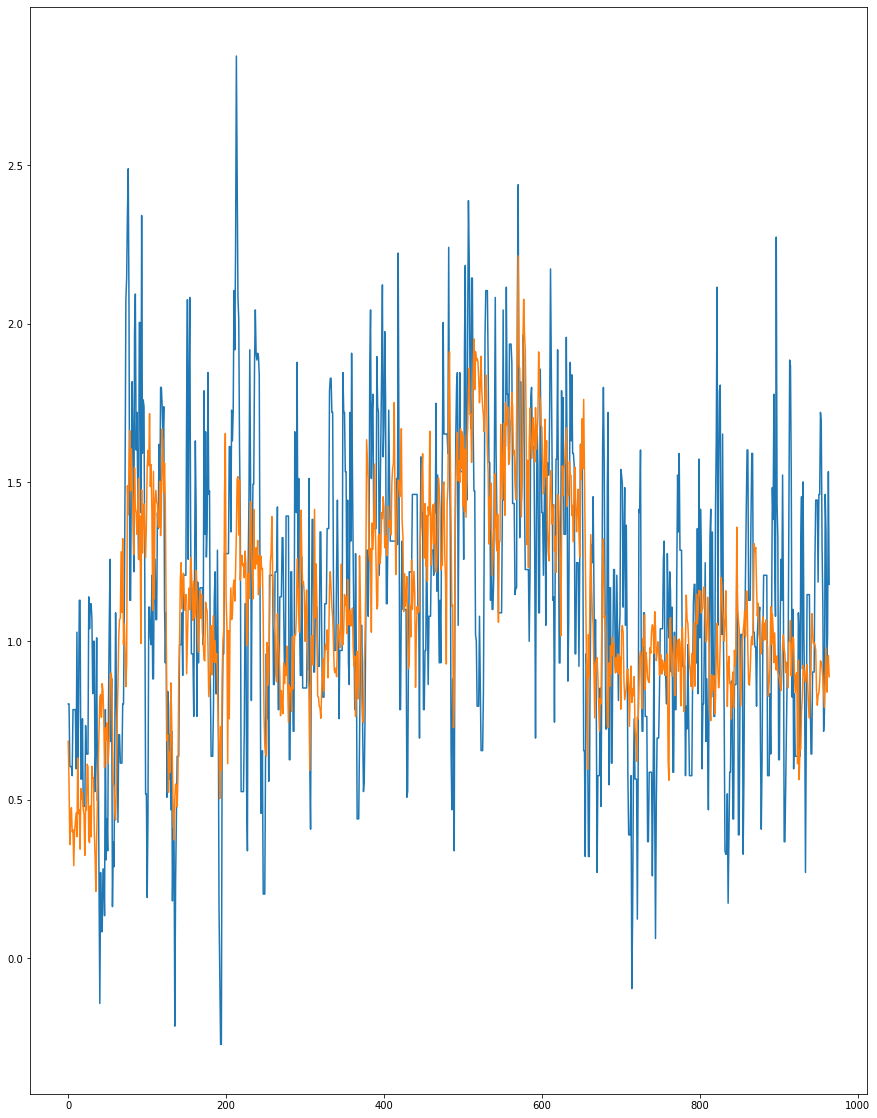

In [54]:
u_learn1, y_learn1 = prepareSignals(scaledDataFrames[1], inputsdp, outputdp)
u_verif1, y_verif1 = prepareSignals(scaledDataFrames[1], inputsdp, outputdp)
numberOfSamples = y_learn1.shape[0]
output_learn_cut1 = y_learn1[maxDelay : numberOfSamples - maxOrder]
output_verif_cut1 = y_verif1[maxDelay : numberOfSamples - maxOrder]
A_learn1 = createModelMatrix(u_learn1, optimM)

data_idx_1 = maxOrder+maxDelay+1
u_verif_wip_1 = np.array(u_verif1[0:data_idx_1],copy=True)
A_verif_1 = createModelMatrix(u_verif_wip_1, optimM)
    
model_outputs_1 = np.array([])
for i in range(data_idx_1, data_idx_1+len(output_learn_cut1)):
    output_model_verif1 = model.predict(A_verif_1)
    model_outputs_1 = np.append(model_outputs_1, output_model_verif1)
    u_verif_wip_1 = np.vstack((u_verif_wip_1, u_verif1[data_idx_1:data_idx_1+1]))[1:]
    data_idx_1 += 1
    u_verif_wip_1[-1][-1] = output_model_verif1[-1]
    A_verif_1 = createModelMatrix(u_verif_wip_1, optimM) 
        
verif_score1 = r2_score(output_verif_cut1, model_outputs_1)
print(verif_score1)

# plot data
plt.rcParams['figure.figsize'] = [15, 20]
plt.plot(output_verif_cut1)
plt.plot(model_outputs_1)
pdres = pd.DataFrame(np.array([output_verif_cut1[:,0], model_outputs_1]).transpose())
pdres.to_csv("./results/genetic/dp_1.csv", index=False, header=False)

0.5044104506977026


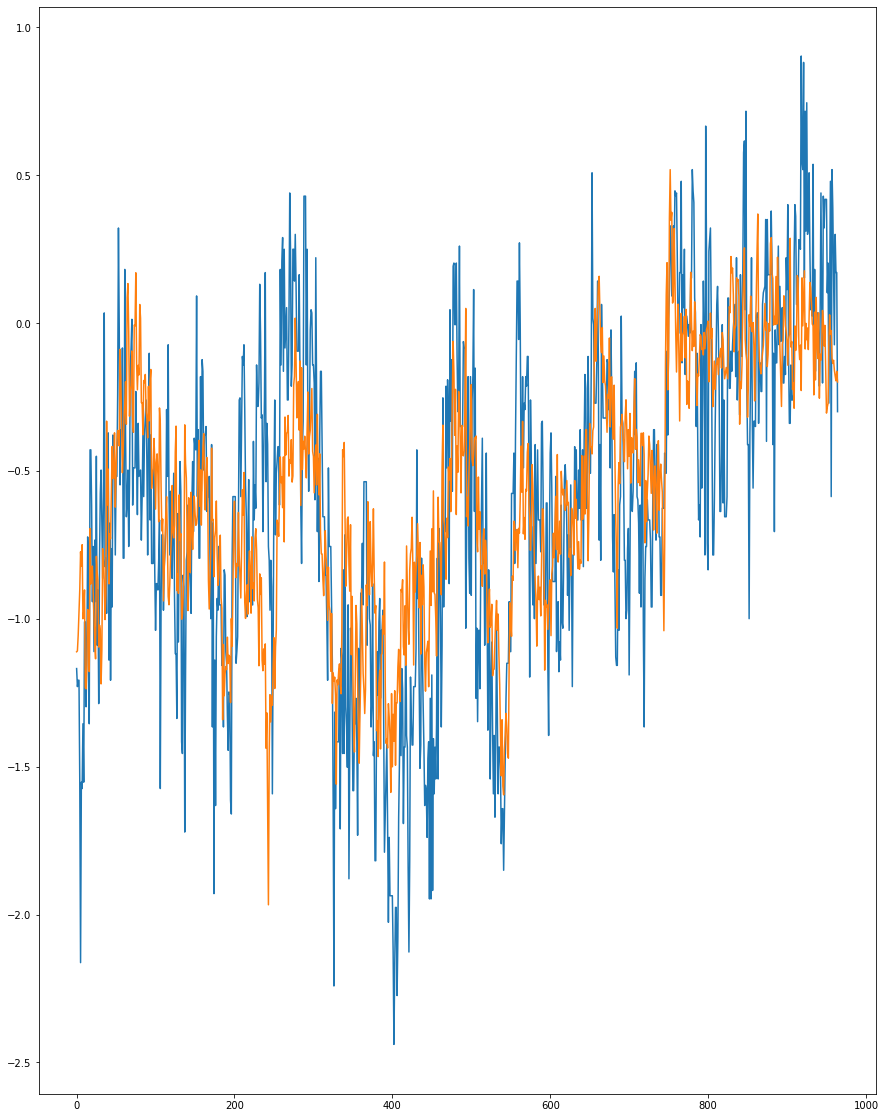

In [55]:
u_learn2, y_learn2 = prepareSignals(scaledDataFrames[2], inputsdp, outputdp)
u_verif2, y_verif2 = prepareSignals(scaledDataFrames[2], inputsdp, outputdp)
numberOfSamples = y_learn2.shape[0]
output_learn_cut2 = y_learn2[maxDelay : numberOfSamples - maxOrder]
output_verif_cut2 = y_verif2[maxDelay : numberOfSamples - maxOrder]
A_learn2 = createModelMatrix(u_learn2, optimM)
#

data_idx_2 = maxOrder+maxDelay+1
u_verif_wip_2 = np.array(u_verif2[0:data_idx_2],copy=True)
A_verif_2 = createModelMatrix(u_verif_wip_2, optimM)
    
model_outputs_2 = np.array([])
for i in range(data_idx_2, data_idx_2+len(output_verif_cut2)):
    output_model_verif2 = model.predict(A_verif_2)
    model_outputs_2 = np.append(model_outputs_2, output_model_verif2)
    u_verif_wip_2 = np.vstack((u_verif_wip_2, u_verif2[data_idx_2:data_idx_2+1]))[1:]
    data_idx_2 += 1
    u_verif_wip_2[-1][-1] = output_model_verif2[-1]
    A_verif_2 = createModelMatrix(u_verif_wip_2, optimM) 
        
verif_score2 = r2_score(output_verif_cut2, model_outputs_2)
print(verif_score2)

# plot data
plt.rcParams['figure.figsize'] = [15, 20]
plt.plot(output_verif_cut2)
plt.plot(model_outputs_2)
pdres = pd.DataFrame(np.array([output_verif_cut2[:,0], model_outputs_2]).transpose())
pdres.to_csv("./results/genetic/dp_2.csv", index=False, header=False)

0.5002230342502603


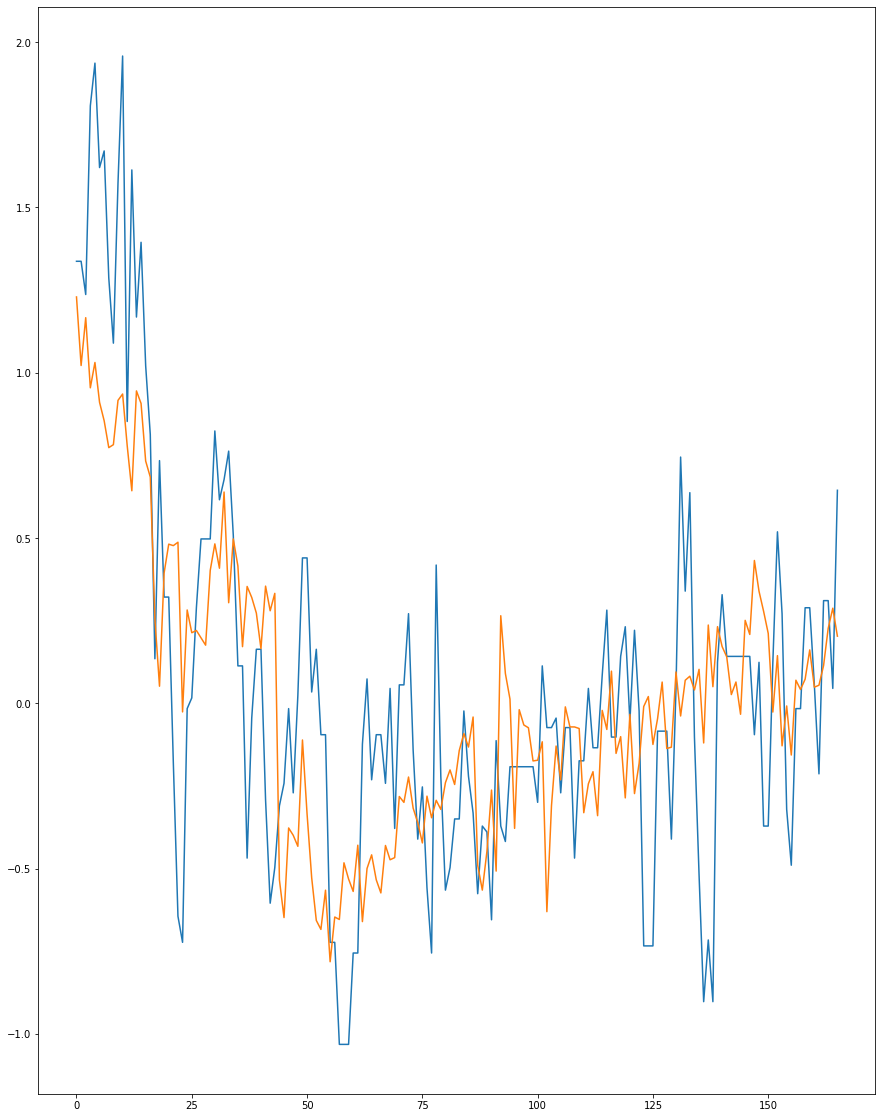

In [56]:
u_learn3, y_learn3 = prepareSignals(scaledDataFrames[3], inputsdp, outputdp)
u_verif3, y_verif3 = prepareSignals(scaledDataFrames[3], inputsdp, outputdp)
numberOfSamples = y_learn3.shape[0]

output_learn_cut3 = y_learn3[maxDelay : numberOfSamples - maxOrder]
output_verif_cut3 = y_verif3[maxDelay : numberOfSamples - maxOrder]
A_learn3 = createModelMatrix(u_learn3, optimM)
#

data_idx_3 = maxOrder+maxDelay+1
u_verif_wip_3 = np.array(u_verif3[0:data_idx_3],copy=True)
A_verif_3 = createModelMatrix(u_verif_wip_3, optimM)
    
model_outputs_3 = np.array([])
for i in range(data_idx_3, data_idx_3+len(output_verif_cut3)):
    output_model_verif3 = model.predict(A_verif_3)
    model_outputs_3 = np.append(model_outputs_3, output_model_verif3)
    u_verif_wip_3 = np.vstack((u_verif_wip_3, u_verif3[data_idx_3:data_idx_3+1]))[1:]
    data_idx_3 += 1
    u_verif_wip_3[-1][-1] = output_model_verif3[-1]
    A_verif_3 = createModelMatrix(u_verif_wip_3, optimM) 
        
verif_score3 = r2_score(output_verif_cut3, model_outputs_3)
print(verif_score3)

# plot data
plt.rcParams['figure.figsize'] = [15, 20]
plt.plot(output_verif_cut3)
plt.plot(model_outputs_3)
pdres = pd.DataFrame(np.array([output_verif_cut3[:,0], model_outputs_3]).transpose())
pdres.to_csv("./results/genetic/dp_3.csv", index=False, header=False)

In [60]:
print(model.coef_)

[ 4.21896897e-01 -3.75023992e-03 -3.63025405e-01 -1.04496016e-01
  1.48488680e-03 -1.14179235e-01 -1.14179235e-01 -1.14179235e-01
  8.06373351e-01 -2.27444105e-01 -7.98561750e-01  7.09969394e-01
  4.91779163e-01 -5.84078090e-01  1.57339862e+00 -2.43214827e+00
  4.80622278e-01 -2.88734895e-01  9.12393486e-01 -7.71006962e-01
  2.64209014e-01  4.53034088e-02  1.75784383e-01 -3.62549630e-03
 -1.78872515e-01  2.77305131e-01 -2.44774075e-01 -5.43917762e-02
 -2.46194987e-01  1.47647325e-01  1.88483913e-01 -6.39974725e-02
  2.88082603e-01  4.91933138e-02  5.53635260e-02 -7.85043696e-03
  3.58231462e-02 -2.06278852e-02 -6.34965497e-03 -1.83294929e-01
  1.60074352e-01 -2.07179118e-01 -7.48879221e-02  1.88073548e-01
 -1.49408969e-01  2.05190358e+00 -4.52869473e-01 -6.35798722e-01
 -4.37034920e-01  6.08054483e-01  9.00125495e-04 -2.45551681e-02
 -2.49152129e-03  2.79539783e-02  3.29043875e-01 -4.79831714e-01
  4.70329275e-01 -2.56826163e-01 -1.32975143e-01 -3.79879470e-02
  5.51421732e-02  2.42738